# 필요한 함수 불러오기

In [1]:
# import the dependent libraries
import numpy as np
import os
from glob import glob
import scipy.io as sio
from skimage.io import imread, imsave
from skimage.transform import rescale, resize
from time import time
import argparse
import ast
import cv2
import matplotlib.pyplot as plt
import sys

from api import PRN

from utils.estimate_pose import estimate_pose
from utils.rotate_vertices import frontalize
from utils.render_app import get_visibility, get_uv_mask, get_depth_image
from utils.write import write_obj_with_colors, write_obj_with_texture

# 변수 초기화

In [2]:
# parameter inlitialization
inputDir = './test/1.jpg' # default
name = '1'
outputDir = './test/result/1_1.jpg' # default
gpu = '0'
isDlib = True
is3d = True
isMat = False
isKpt = False
isPose = False
isShow = False
isImage = False
isFront = False
isDepth = True
isTexture = False
isMask = False
texture_size = 256

if isShow or isTexture:
    import cv2
    from utils.cv_plot import plot_kpt, plot_vertices, plot_pose_box

os.environ['CUDA_VISIBLE_DEVICES'] = gpu # GPU number, -1 for CPU

# 입력 이미지 불러오기

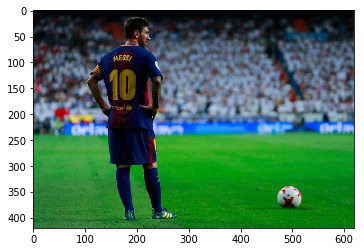

(420, 620, 3)


In [3]:
# -------- load data
image_path = inputDir
save_folder = outputDir
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
    
#name = image_path.strip().split('/')[-1][:-4]
# read image
image = imread(image_path)
[h, w, c] = image.shape
if c>3:
    image = image[:,:,:3]

max_size = max(image.shape[0], image.shape[1])
if max_size> 1000:
    image = rescale(image, 1000./max_size)
    image = (image*255).astype(np.uint8)
    
plt.imshow(image)
plt.show()
print(image.shape)

# Dlib 얼굴 검출기를 이용한 얼굴 부분 잘라내기

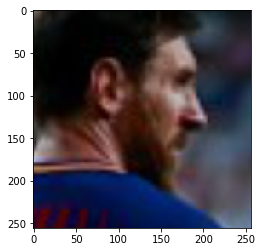

In [4]:
# Load face detctor from  Dlib to generate face bbox inforamtion
import matplotlib.patches as patches
from skimage.transform import estimate_transform, warp

image_path = inputDir
save_folder = outputDir
if not os.path.exists(save_folder):
    os.mkdir(save_folder)
    
#name = image_path.strip().split('/')[-1][:-4]
# read image
image = imread(image_path)
[h, w, c] = image.shape
if c>3:
    image = image[:,:,:3]

max_size = max(image.shape[0], image.shape[1])
if max_size> 1000:
    image = rescale(image, 1000./max_size)
    image = (image*255).astype(np.uint8) 

resolution_inp = 256
resolution_op = 256
prefix = '.'
if image.ndim < 3:
    image = np.tile(image[:,:,np.newaxis], [1,1,3])

# load face detector model
import dlib
detector_path = os.path.join(prefix, 'Data/net-data/mmod_human_face_detector.dat')
face_detector = dlib.cnn_face_detection_model_v1(detector_path)
detected_faces = face_detector(image, 1)

if len(detected_faces) == 0:
    print('warning: no detected face')
    
d = detected_faces[0].rect ## only use the first detected face (assume that each input image only contains one face)
left = d.left(); right = d.right(); top = d.top(); bottom = d.bottom()
old_size = (right - left + bottom - top)/2
center = np.array([right - (right - left) / 2.0, bottom - (bottom - top) / 2.0 + old_size*0.14])
size = int(old_size*1.58)

# crop image and resize it to predefined resolution
src_pts = np.array([[center[0]-size/2, center[1]-size/2], [center[0] - size/2, center[1]+size/2], [center[0]+size/2, center[1]-size/2]])
DST_PTS = np.array([[0,0], [0, resolution_inp - 1], [resolution_inp - 1, 0]])
tform = estimate_transform('similarity', src_pts, DST_PTS)

image = image/255.
cropped_image = warp(image, tform.inverse, output_shape=(resolution_inp, resolution_inp))
plt.imshow(cropped_image)
plt.show()

# PRN 네트워크 구조

In [5]:
# The Architecture of Position map Regression Network
import tensorflow as tf
import tensorflow.contrib.layers as tcl
from tensorflow.contrib.framework import arg_scope
import numpy as np
import os

def resBlock(x, num_outputs, kernel_size = 4, stride=1, activation_fn=tf.nn.relu, normalizer_fn=tcl.batch_norm, scope=None):
    assert num_outputs%2==0 #num_outputs must be divided by channel_factor(2 here)
    with tf.variable_scope(scope, 'resBlock'):
        shortcut = x
        if stride != 1 or x.get_shape()[3] != num_outputs:
            shortcut = tcl.conv2d(shortcut, num_outputs, kernel_size=1, stride=stride, 
                        activation_fn=None, normalizer_fn=None, scope='shortcut')
        x = tcl.conv2d(x, num_outputs/2, kernel_size=1, stride=1, padding='SAME')
        x = tcl.conv2d(x, num_outputs/2, kernel_size=kernel_size, stride=stride, padding='SAME')
        x = tcl.conv2d(x, num_outputs, kernel_size=1, stride=1, activation_fn=None, padding='SAME', normalizer_fn=None)

        x += shortcut       
        x = normalizer_fn(x)
        x = activation_fn(x)
    return x


class resfcn256(object):
    def __init__(self, resolution_inp = 256, resolution_op = 256, channel = 3, name = 'resfcn256'):
        self.name = name
        self.channel = channel
        self.resolution_inp = resolution_inp
        self.resolution_op = resolution_op

    def __call__(self, x, is_training = True):
        with tf.variable_scope(self.name) as scope:
            with arg_scope([tcl.batch_norm], is_training=is_training, scale=True):
                with arg_scope([tcl.conv2d, tcl.conv2d_transpose], activation_fn=tf.nn.relu, 
                                     normalizer_fn=tcl.batch_norm, 
                                     biases_initializer=None, 
                                     padding='SAME',
                                     weights_regularizer=tcl.l2_regularizer(0.0002)):
                    size = 16  
                    # x: s x s x 3
                    se = tcl.conv2d(x, num_outputs=size, kernel_size=4, stride=1) # 256 x 256 x 16
                    se = resBlock(se, num_outputs=size * 2, kernel_size=4, stride=2) # 128 x 128 x 32
                    se = resBlock(se, num_outputs=size * 2, kernel_size=4, stride=1) # 128 x 128 x 32
                    se = resBlock(se, num_outputs=size * 4, kernel_size=4, stride=2) # 64 x 64 x 64
                    se = resBlock(se, num_outputs=size * 4, kernel_size=4, stride=1) # 64 x 64 x 64
                    se = resBlock(se, num_outputs=size * 8, kernel_size=4, stride=2) # 32 x 32 x 128
                    se = resBlock(se, num_outputs=size * 8, kernel_size=4, stride=1) # 32 x 32 x 128
                    se = resBlock(se, num_outputs=size * 16, kernel_size=4, stride=2) # 16 x 16 x 256
                    se = resBlock(se, num_outputs=size * 16, kernel_size=4, stride=1) # 16 x 16 x 256
                    se = resBlock(se, num_outputs=size * 32, kernel_size=4, stride=2) # 8 x 8 x 512
                    se = resBlock(se, num_outputs=size * 32, kernel_size=4, stride=1) # 8 x 8 x 512

                    pd = tcl.conv2d_transpose(se, size * 32, 4, stride=1) # 8 x 8 x 512 
                    pd = tcl.conv2d_transpose(pd, size * 16, 4, stride=2) # 16 x 16 x 256 
                    pd = tcl.conv2d_transpose(pd, size * 16, 4, stride=1) # 16 x 16 x 256 
                    pd = tcl.conv2d_transpose(pd, size * 16, 4, stride=1) # 16 x 16 x 256 
                    pd = tcl.conv2d_transpose(pd, size * 8, 4, stride=2) # 32 x 32 x 128 
                    pd = tcl.conv2d_transpose(pd, size * 8, 4, stride=1) # 32 x 32 x 128 
                    pd = tcl.conv2d_transpose(pd, size * 8, 4, stride=1) # 32 x 32 x 128 
                    pd = tcl.conv2d_transpose(pd, size * 4, 4, stride=2) # 64 x 64 x 64 
                    pd = tcl.conv2d_transpose(pd, size * 4, 4, stride=1) # 64 x 64 x 64 
                    pd = tcl.conv2d_transpose(pd, size * 4, 4, stride=1) # 64 x 64 x 64 
                    
                    pd = tcl.conv2d_transpose(pd, size * 2, 4, stride=2) # 128 x 128 x 32
                    pd = tcl.conv2d_transpose(pd, size * 2, 4, stride=1) # 128 x 128 x 32
                    pd = tcl.conv2d_transpose(pd, size, 4, stride=2) # 256 x 256 x 16
                    pd = tcl.conv2d_transpose(pd, size, 4, stride=1) # 256 x 256 x 16

                    pd = tcl.conv2d_transpose(pd, 3, 4, stride=1) # 256 x 256 x 3
                    pd = tcl.conv2d_transpose(pd, 3, 4, stride=1) # 256 x 256 x 3
                    pos = tcl.conv2d_transpose(pd, 3, 4, stride=1, activation_fn = tf.nn.sigmoid)#, padding='SAME', weights_initializer=tf.random_normal_initializer(0, 0.02))
                                
                    return pos
    @property
    def vars(self):
        return [var for var in tf.global_variables() if self.name in var.name]

# load PRN trained model first
prefix = '.'
prn_path = os.path.join(prefix, 'Data/net-data/256_256_resfcn256_weight')
if not os.path.isfile(prn_path + '.data-00000-of-00001'):
    print("please download PRN trained model first.")
    exit()

# -- hyper settings
resolution_inp = 256
resolution_op = 256
MaxPos = resolution_inp*1.1

# network type
network = resfcn256(resolution_inp, resolution_op)

#tensflow initialization
x = tf.placeholder(tf.float32, shape=[None, resolution_inp, resolution_inp, 3])  
x_op = network(x, is_training = False)
sess = tf.Session(config=tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True)))
tf.train.Saver(network.vars).restore(sess, prn_path) 

pos = sess.run(x_op, feed_dict = {x: cropped_image[np.newaxis, :,:,:]})
pos = np.squeeze(pos)
cropped_pos = pos*MaxPos
#print(cropped_pos)


# restore all_vertices of cropped face
cropped_vertices = np.reshape(cropped_pos, [-1, 3]).T
z = cropped_vertices[2,:].copy()/tform.params[0,0]
cropped_vertices[2,:] = 1
vertices = np.dot(np.linalg.inv(tform.params), cropped_vertices)
vertices = np.vstack((vertices[:2,:], z))
pos = np.reshape(vertices.T, [resolution_op, resolution_op, 3])
print(pos.shape)

INFO:tensorflow:Restoring parameters from ./Data/net-data/256_256_resfcn256_weight
(256, 256, 3)


# 얼굴 재구성에 사용할 3D vertices, Depth, 색상정보(UV map), 얼굴 포즈 구하기

/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


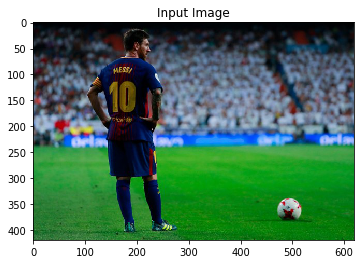

(43867, 3)
[[0.03529412 0.00784314 0.03529412]
 [0.01960784 0.00784314 0.03529412]
 [0.00392157 0.         0.01960784]
 ...
 [0.23921569 0.14901961 0.02745098]
 [0.23921569 0.14901961 0.02745098]
 [0.23921569 0.14901961 0.02745098]]


/usr/local/lib/python2.7/dist-packages/skimage/io/_io.py:140: UserWarning: ./test/result/1_1.jpg/1_depth.jpg is a low contrast image
  warn('%s is a low contrast image' % fname)


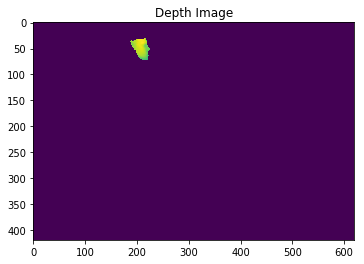

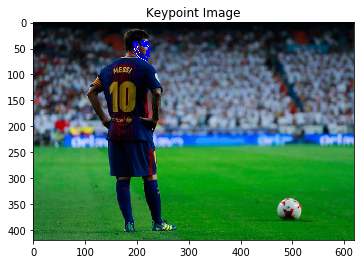

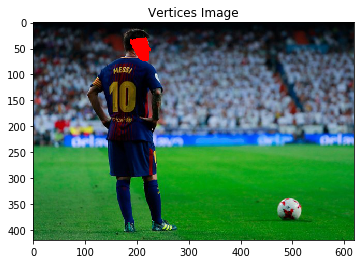

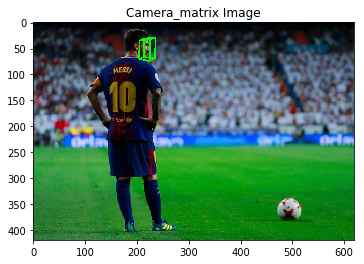

In [6]:
# Get 3D vertices
import numpy as np
import os
from skimage.io import imread, imsave
from skimage.transform import estimate_transform, warp
from time import time
import ast

from api import PRN

from utils.estimate_pose import estimate_pose
from utils.cv_plot import plot_kpt, plot_vertices, plot_pose_box
from utils.rotate_vertices import frontalize
from utils.render_app import get_visibility, get_uv_mask, get_depth_image
from utils.write import write_obj_with_colors, write_obj_with_texture

is3d = True
isMat = True
isKpt = False
isPose = False
isShow = True
isImage = True
isFront = False
isDepth = True
isTexture = False
isMask = False

# uv file
uv_kpt_ind = np.loadtxt(prefix + '/Data/uv-data/uv_kpt_ind.txt').astype(np.int32) # 2 x 68 get kpt
face_ind = np.loadtxt(prefix + '/Data/uv-data/face_ind.txt').astype(np.int32) # get valid vertices in the pos map
triangles = np.loadtxt(prefix + '/Data/uv-data/triangles.txt').astype(np.int32) # ntri x 3

#get vertices
'''
get_vertices(self, pos):
Args:
    pos: the 3D position map. shape = (256, 256, 3).
Returns:
    vertices: the vertices(point cloud). shape = (num of points, 3). n is about 40K here.
'''
all_vertices = np.reshape(pos, [resolution_op**2, -1])
vertices = all_vertices[face_ind, :]

# print(vertices.shape)

# 3D vertices
if isFront:
    save_vertices = frontalize(vertices)
else:
    save_vertices = vertices.copy()
save_vertices[:,1] = h - 1 - save_vertices[:,1]

# 입력 이미지
if isImage:
    imsave(os.path.join(save_folder, name + '.jpg'), image)
    plt.imshow(image)
    plt.title("Input Image")
    plt.show()


# corresponding colors
'''
get_colors(self, image, vertices):
Args:
    pos: the 3D position map. shape = (256, 256, 3).
Returns:
    colors: the corresponding colors of vertices. shape = (num of points, 3). n is 45128 here.
'''
if is3d:
    [h, w, _] = image.shape
    vertices[:,0] = np.minimum(np.maximum(vertices[:,0], 0), w - 1)  # x
    vertices[:,1] = np.minimum(np.maximum(vertices[:,1], 0), h - 1)  # y
    ind = np.round(vertices).astype(np.int32)
    colors = image[ind[:,1], ind[:,0], :] # n x 3

    print(colors.shape)
    print(colors)
    
    if isTexture:
        if args.texture_size != 256:
            pos_interpolated = resize(pos, (texture_size, texture_size), preserve_range = True)
        else:
            pos_interpolated = pos.copy()
        texture = cv2.remap(image, pos_interpolated[:,:,:2].astype(np.float32), None, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT,borderValue=(0))
        if isMask:
            vertices_vis = get_visibility(vertices, triangles, h, w)
            uv_mask = get_uv_mask(vertices_vis, triangles, uv_coords, h, w, resolution_op)
            uv_mask = resize(uv_mask, (texture_size, texture_size), preserve_range = True)
            texture = texture*uv_mask[:,:,np.newaxis]
        write_obj_with_texture(os.path.join(save_folder, name + '.obj'), save_vertices, triangles, texture, prn.uv_coords/prn.resolution_op)#save 3d face with texture(can open with meshlab)
    else:
        write_obj_with_colors(os.path.join(save_folder, name + '.obj'), save_vertices, triangles, colors) #save 3d face(can open with meshlab)

# 깊이 이미지
if isDepth:
    depth_image = get_depth_image(vertices, triangles, h, w, True)
    depth = get_depth_image(vertices, triangles, h, w)
    imsave(os.path.join(save_folder, name + '_depth.jpg'), depth_image)
    sio.savemat(os.path.join(save_folder, name + '_depth.mat'), {'depth':depth})
    plt.imshow(depth_image)
    plt.title("Depth Image")
    plt.show()

    
if isMat:
        sio.savemat(os.path.join(save_folder, name + '_mesh.mat'), {'vertices': vertices, 'colors': colors, 'triangles': triangles})

if isKpt or isShow:
    '''
    Args:
        pos: the 3D position map. shape = (256, 256, 3).
    Returns:
        kpt: 68 3D landmarks. shape = (68, 3).
    '''
    kpt = pos[uv_kpt_ind[1,:], uv_kpt_ind[0,:], :]
    np.savetxt(os.path.join(save_folder, name + '_kpt.txt'), kpt)

# 얼굴 자세 추정 이미지
if isPose or isShow:
    # estimate pose
    camera_matrix, pose = estimate_pose(vertices)
    np.savetxt(os.path.join(save_folder, name + '_pose.txt'), pose) 
    np.savetxt(os.path.join(save_folder, name + '_camera_matrix.txt'), camera_matrix) 

    np.savetxt(os.path.join(save_folder, name + '_pose.txt'), pose)

if isShow:
    # ---------- Plot
    image_pose = plot_pose_box(image, camera_matrix, kpt)
    
    img1 = plot_kpt(image, kpt)
    plt.imshow(plot_kpt(image, kpt))
    plt.title("Keypoint Image")
    plt.show()
    
    img2 = plot_vertices(image, vertices)
    plt.imshow(plot_vertices(image, vertices))
    plt.title("Vertices Image")
    plt.show()
    
    img3 = plot_pose_box(image, camera_matrix, kpt)
    plt.imshow(plot_pose_box(image, camera_matrix, kpt))
    plt.title("Camera_matrix Image")
    plt.show()